In the first time we used some python methods to reorganize the dataset.
We reorganized to have 50% of the data on training, 35% on validation and 15% on test.
In the subdirectory we also made so equilibrium between the 3 classes as follow, bacteria, virus and normal.
The final repartition is as follow : 

Train (50%): 
- VIRUS : 747
- BACTERIA : 747
- NORMAL : 747

Validation (35%) : 
- VIRUS : 523
- BACTERIA : 523
- NORMALTrain : 523

Test (15%) : 
- VIRUS : 223
- BACTERIA : 223
- NORMAL : 223

In [26]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, LearningRateScheduler, ReduceLROnPlateau

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Rescale pixel values from [0, 255] to [0, 1] (normalization)
    rotation_range=10,           # Randomly rotate images by up to 10 degrees 
    width_shift_range=0.3,       # Randomly shift images horizontally by up to 30% of the width 
    height_shift_range=0.3,      # Randomly shift images vertically by up to 30% of the height
    fill_mode='nearest',         # Fill in missing pixels with the nearest pixel
    shear_range=0.2,             # Randomly shear images by up to 20%
    zoom_range=0.2,              # Randomly zoom in on images by up to 20%
    horizontal_flip=True,        # Randomly flip images horizontally
    brightness_range=[0.7, 1.3]  # Change the brightness of images
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Data directories
train_dir = './train'
validation_dir = './val'

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(190, 190),     # Resize images to 150x150 easyer to process and less computationally expensive 
    batch_size=15,              # Number of images to process at a time
    class_mode='categorical',   # Categorical labels for multi-class classification (NORMAL, PNEUMONIA, VIRUS)
    shuffle=True,               # Shuffle the data for better training
    color_mode='grayscale'      # Load images in grayscale
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(190, 190),
    batch_size=15,
    class_mode='categorical',
    shuffle=True,
    color_mode='grayscale'
)   

# Model definition
model = Sequential([
    Input(shape=(190, 190, 1)),  # Input layer with images of size 190x190 and 1 color channel for grayscale

    #First convolutional block with 32 filters to detect 32 type of simple features with 3x3 kernel to analyze 3x3 pixel areas
    Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(0.001)),  # First convolutional layer
    BatchNormalization(),                                              # Batch normalization
    LeakyReLU(negative_slope=0.1),                                     # Leaky ReLU activation
    MaxPooling2D(2, 2),                                                # Spatial downsampling
    Dropout(0.3),                                                      # Dropout to reduce overfitting

    Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.001)),  # Second convolutional layer with 64 filters
    BatchNormalization(),
    LeakyReLU(negative_slope=0.1),
    MaxPooling2D(2, 2),
    Dropout(0.3),

    Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.001)),  # Third convolutional layer with 128 filters
    BatchNormalization(),  
    LeakyReLU(negative_slope=0.1),
    MaxPooling2D(2, 2),
    Dropout(0.3),

    Flatten(),                                                          # Flatten the features for dense layers
    Dense(512, kernel_regularizer=l2(0.001)),                           # Dense layer with 512 or 256 neurons
    BatchNormalization(),  
    LeakyReLU(negative_slope=0.1),
    Dropout(0.5),

    Dense(3, activation='softmax')                                      # Output layer for classification into 3 classes
])

# Model compilation
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



Found 2241 images belonging to 3 classes.
Found 1569 images belonging to 3 classes.


First of all we define our model like this : 

- We create a Conv2D layer (convolutionnal layer) to interract with the image and extract the features such has angles, edges etc
- We use 32 filters because it has been empiricaly proven that power of 2 works better and especially 32 for to start image recognition
- We apply the batch normalisation to stabilize and fasten the process by re-centering and rescaling
- We then use the LeakyRelu to add some non-linearity and combine features learned in previous layer (for neurones to learn when the value is negative)
- We then add some maxpooling to re-center and re-scaling the input and the features and reduce dimension
- Finally we add some dropout to improve generalization by disabling 30% of the neurons randomly during training 

After 3 Convolutionnal block to detect the feature part we then proceed to the categorisation part with : 
- A flatten layer to flatten the features for dense layers (convert 3D features arrays into 1D feature array)
- a Dense layer with 512 neurons fully connected layer for classification, each neuron recieve data from previous layer
- A batch normalization again to stabilize and fasten the process
- A leakyRelu to add some non-linearity and combine feature for a final time
- A final drop out to improve generalization by disabling 50% of the neurons randomly during training 

We then have the output layer for the classification into 3 classe : 
- Dense layer with activation softmax for a distribution probability

In [27]:

# Model compilation
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Function to combine history
def append_history(histories, new_history):
    for key in new_history.history.keys():
        if key in histories:
            histories[key] += new_history.history[key]
        else:
            histories[key] = new_history.history[key]
    return histories


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001) # Reduce learning by 5 if the validation loss plateaus during 5 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) # Stop training if the validation loss does not decrease for 10 epochs
save_model = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min') #save only if the validation loss decreases

callbacks = [reduce_lr, early_stopping, save_model]

# Training the model and combining history
combined_history = {}
for epoch in range(20):
    train_generator.reset()
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=1,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        callbacks= callbacks
    )
    combined_history = append_history(combined_history, history)


/Users/arnaud/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


150/150 ━━━━━━━━━━━━━━━━━━━━ 39s 235ms/step - accuracy: 0.5108 - loss: 3.1417 - val_accuracy: 0.3333 - val_loss: 4.4773 - learning_rate: 0.0010
150/150 ━━━━━━━━━━━━━━━━━━━━ 35s 227ms/step - accuracy: 0.6149 - loss: 2.4395 - val_accuracy: 0.3378 - val_loss: 3.6879 - learning_rate: 0.0010
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 236ms/step - accuracy: 0.6006 - loss: 2.0360 - val_accuracy: 0.3926 - val_loss: 2.3386 - learning_rate: 0.0010
150/150 ━━━━━━━━━━━━━━━━━━━━ 46s 306ms/step - accuracy: 0.6468 - loss: 1.7579 - val_accuracy: 0.5997 - val_loss: 1.6666 - learning_rate: 0.0010
150/150 ━━━━━━━━━━━━━━━━━━━━ 47s 312ms/step - accuracy: 0.6475 - loss: 1.5987 - val_accuracy: 0.3639 - val_loss: 2.3200 - learning_rate: 0.0010
150/150 ━━━━━━━━━━━━━━━━━━━━ 45s 299ms/step - accuracy: 0.6619 - loss: 1.5409 - val_accuracy: 0.5417 - val_loss: 1.9464 - learning_rate: 0.0010
150/150 ━━━━━━━━━━━━━━━━━━━━ 47s 310ms/step - accuracy: 0.6949 - loss: 1.3660 - val_accuracy: 0.5825 - val_loss: 1.8300 - learning_rate:

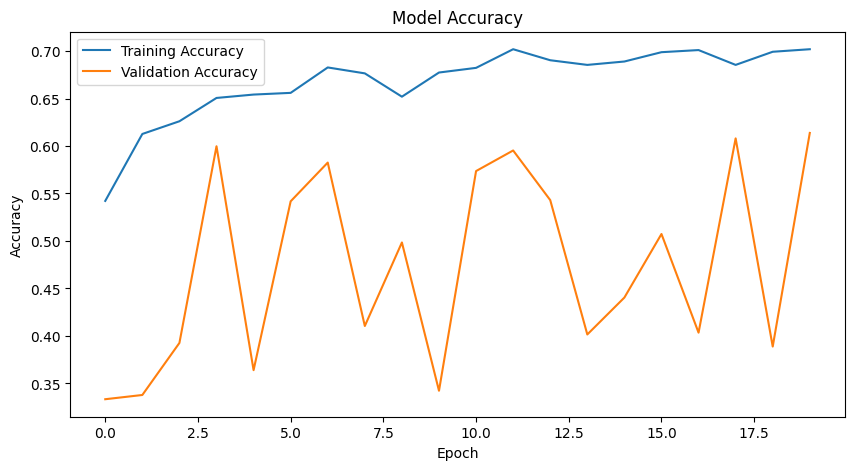

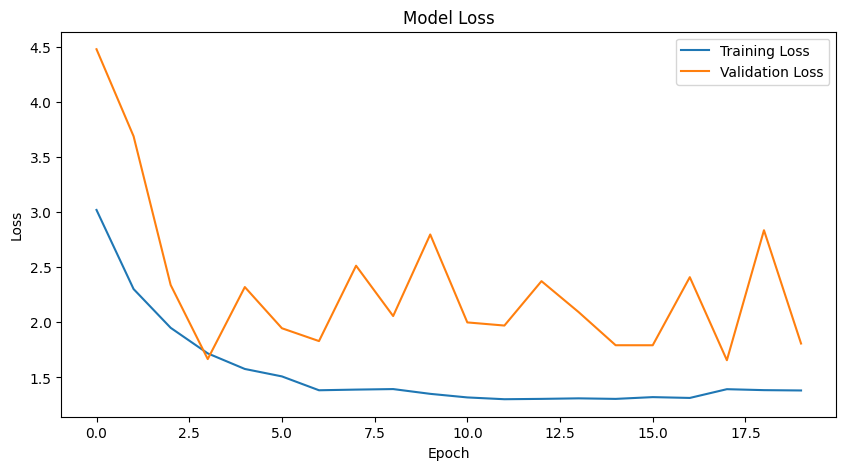

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(combined_history['accuracy'], label='Training Accuracy')
plt.plot(combined_history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(combined_history['loss'], label='Training Loss')
plt.plot(combined_history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [29]:
# Prepare the test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_dir = './test'
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(190, 190), batch_size=20, class_mode='categorical', shuffle=False, color_mode='grayscale'
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f'Test accuracy: {test_accuracy}')
print(f'Test loss: {test_loss}')

Found 669 images belonging to 3 classes.
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.7864 - loss: 1.3351
Test accuracy: 0.7279521822929382
Test loss: 1.363606572151184


After the training we have a 72,8% accuracy on the test data set, testing on new images never seen before by the model and a loss of 1.36 witch is pretty high.

34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step


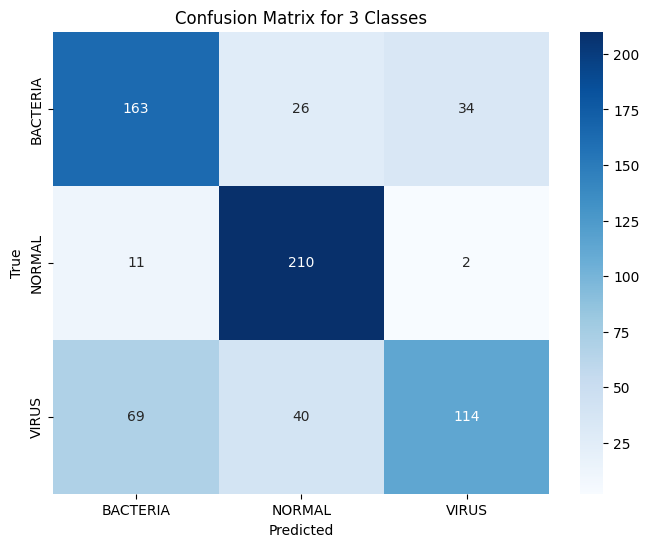

Classification Report for 3 Classes
              precision    recall  f1-score   support

    BACTERIA       0.67      0.73      0.70       223
      NORMAL       0.76      0.94      0.84       223
       VIRUS       0.76      0.51      0.61       223

    accuracy                           0.73       669
   macro avg       0.73      0.73      0.72       669
weighted avg       0.73      0.73      0.72       669



In [30]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions
Y_pred = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

# Get true labels
y_true = test_generator.classes

# Compute the confusion matrix for the 3 classes
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix for the 3 classes
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(test_generator.class_indices.keys()), yticklabels=list(test_generator.class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for 3 Classes')
plt.show()

# Print the classification report for the 3 classes
print('Classification Report for 3 Classes')
target_names = list(test_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=target_names))



Precision: is the ratio of correctly predicted positive to the total predicted positive (TP / (TP + FP))
It show how precise it is when it predict a positive

Recall: is the ratio of correctly predicted positive observations to the all observations in actual class. (TP / (TP + FN))
It show how it identifies most of the positive

- 73% of the bacteria are correctly classified and 94% of normal lungs are correctly classified witch means the model is good a identifying healthy lungs.
- Only 51% of the viral pneumonia are classified such as, meaning the model has a hard time detecting this type of pneumonia such as it should be classified

Overall a 73% accuracy is reached by the CNN model



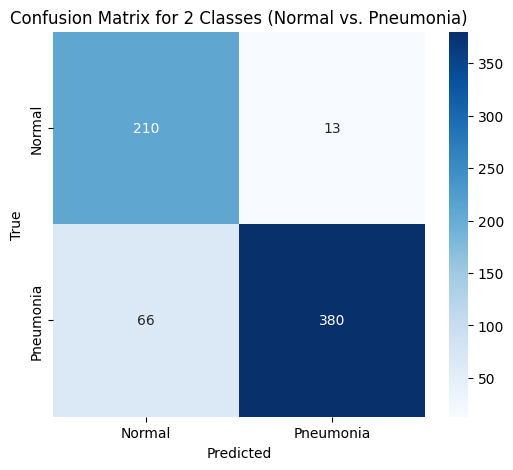

Classification Report for 2 Classes (Normal vs. Pneumonia)
              precision    recall  f1-score   support

      Normal       0.76      0.94      0.84       223
   Pneumonia       0.97      0.85      0.91       446

    accuracy                           0.88       669
   macro avg       0.86      0.90      0.87       669
weighted avg       0.90      0.88      0.88       669



In [31]:

# Transform predictions and true labels into two categories: 'normal' and 'Pneumonia'
y_true_binary = np.where(y_true == test_generator.class_indices['NORMAL'], 0, 1)
y_pred_binary = np.where(y_pred == test_generator.class_indices['NORMAL'], 0, 1)

# Compute the confusion matrix for the binary classification
conf_matrix_binary = confusion_matrix(y_true_binary, y_pred_binary)

# Plot the confusion matrix for the binary classification
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_binary, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for 2 Classes (Normal vs. Pneumonia)')
plt.show()

# Print the classification report for the binary classification
print('Classification Report for 2 Classes (Normal vs. Pneumonia)')
print(classification_report(y_true_binary, y_pred_binary, target_names=['Normal', 'Pneumonia']))


the model identifies 94% of the Normal lungs but with lots of false positive and 97% of the pneumonia detected are actually pneumonia with few false positive

A bit less precise with normal (76%) witch were actually normal lungs

Overall accuracy for Normal VS Pneumonia is 88%